In [ ]:
# Document Collection, Tokenizer, Normalization Pipeline on IMDB dataset
import os
import tarfile
import random
import pandas as pd
import numpy as np
import nltk
import logging
import time
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
nltk.download('punkt')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Load IMDB reviews dataset from TensorFlow Datasets
# as_supervised=True gives (text, label) pairs
(ds_train, ds_test), ds_info = tfds.load(
    "imdb_reviews",
    split=["train", "test"],
    as_supervised=True,
    with_info=True
)

# --- Step 2: Collect 1000 positive + 1000 negative from the training split ---

documents = []
pos_count = 0
neg_count = 0
TARGET_PER_CLASS = 1000

# Convert TFDS dataset to NumPy for easy iteration
for text, label in tfds.as_numpy(ds_train.shuffle(25000, seed=42)):
    text_str = text.decode("utf-8")
    label_int = int(label)

    if label_int == 1 and pos_count < TARGET_PER_CLASS:
        documents.append((text_str, "positive"))
        pos_count += 1
    elif label_int == 0 and neg_count < TARGET_PER_CLASS:
        documents.append((text_str, "negative"))
        neg_count += 1

    if pos_count >= TARGET_PER_CLASS and neg_count >= TARGET_PER_CLASS:
        break

print(f"Collected {pos_count} positive and {neg_count} negative reviews.")

# Shuffle the dataset
random.shuffle(documents)

# Convert to pandas DataFrame
df = pd.DataFrame(documents, columns=["text", "label"])
df.head()

2025-12-05 15:36:25,013 : INFO : No config specified, defaulting to config: imdb_reviews/plain_text
2025-12-05 15:36:25,038 : WARNING : Variant folder C:\Users\Rohit\tensorflow_datasets\imdb_reviews\plain_text\1.0.0 has no dataset_info.json
2025-12-05 15:36:25,039 : INFO : Generating dataset imdb_reviews (C:\Users\Rohit\tensorflow_datasets\imdb_reviews\plain_text\1.0.0)


c:\Conestoga Course Work\AI and ML\Machine Learning Programming\FINAL PROJECT\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 0 url [00:00, ? url/s]2025-12-05 15:36:25,483 : INFO : Downloading http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz into C:\Users\Rohit\tensorflow_datasets\downloads\imdb_reviews\ai.stanfor.edu_amaas_sentime_aclImdb_v1PaujRp-TxjBWz59jHXsMDm5WiexbxzaFQkEnXc3Tvo8.tar.gz.tmp.8a3cc2f6dd3c48b8997f1e6b6fb3ae1b...
Generating splits...:  67%|██████▋   | 2/3 [00:11<00:05,  5.85s/ splits]2025-12-05 15:37:39,315 : INFO : Done writing C:\Users\Rohit\tensorflow_datasets\imdb_reviews\plain_text\incomplete.DC9YS1_1.0.0\imdb_reviews-unsupervised.tfrecord*. Number of examples: 50000 (shards: [50000])
2025-12-05 15:37:39,358 : INFO : Creating a tf.data.Dataset reading 1 f

Dataset imdb_reviews downloaded and prepared to C:\Users\Rohit\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.
Collected 1000 positive and 1000 negative reviews.


,text,label
0,"Laughs, adventure, a good time, a killer sound...",positive
1,Wow...where to begin...picked this up at Big L...,negative
2,"This film aka ""the four hundred blows"" is a mi...",negative
3,This movie is really wack. There is really not...,negative
4,This is a great ending to the show. The fact t...,positive


In [7]:
print("Dataset shape:", df.shape)
print("\nLabel distribution:")
print(df['label'].value_counts())

df[['text', 'label']].head()

Dataset shape: (2000, 2)

Label distribution:
label
positive    1000
negative    1000
Name: count, dtype: int64


,text,label
0,"Laughs, adventure, a good time, a killer sound...",positive
1,Wow...where to begin...picked this up at Big L...,negative
2,"This film aka ""the four hundred blows"" is a mi...",negative
3,This movie is really wack. There is really not...,negative
4,This is a great ending to the show. The fact t...,positive


In [8]:
first_review = df.loc[0, "text"]
first_review_tokens = word_tokenize(first_review)

print("=== FIRST REVIEW (text sample) ===")
print(first_review[:300], "...")

print("\n=== TOKENIZED OUTPUT ===")
print(first_review_tokens[:30])

=== FIRST REVIEW (text sample) ===
Laughs, adventure, a good time, a killer soundtrack, oscar-worthy acting, and special effects/ animitronics like none other, what else could you want in a movie? If you see this will be on the telly, WATCH IT, otherwise, run out now to RENT IT!!! ...

=== TOKENIZED OUTPUT ===
['Laughs', ',', 'adventure', ',', 'a', 'good', 'time', ',', 'a', 'killer', 'soundtrack', ',', 'oscar-worthy', 'acting', ',', 'and', 'special', 'effects/', 'animitronics', 'like', 'none', 'other', ',', 'what', 'else', 'could', 'you', 'want', 'in', 'a']


In [9]:
def normalize_and_remove_stops(tokens):
    """
    1. Converts all tokens to lowercase (Normalization).
    2. Removes common English stop words.
    """
    # 1. Normalization: Convert to lowercase
    normalized_tokens = [token.lower() for token in tokens]

    # 2. Stop Words Removal
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in normalized_tokens if token not in stop_words]
    
    return filtered_tokens

# Process our IMDB review tokens
cleaned_tokens = normalize_and_remove_stops(first_review_tokens)

print("--- NORMALIZATION & STOP WORDS REMOVAL ---")
print(cleaned_tokens[:30])

--- NORMALIZATION & STOP WORDS REMOVAL ---
['laughs', ',', 'adventure', ',', 'good', 'time', ',', 'killer', 'soundtrack', ',', 'oscar-worthy', 'acting', ',', 'special', 'effects/', 'animitronics', 'like', 'none', ',', 'else', 'could', 'want', 'movie', '?', 'see', 'telly', ',', 'watch', ',', 'otherwise']


In [10]:
X = df["text"].values          # raw review text
y = df["label"].values         # "positive" / "negative"

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train size:", len(X_train))
print("Test size :", len(X_test))

Train size: 1500
Test size : 500


In [11]:
vectorizer = TfidfVectorizer(
    max_features=5000,      # limit vocabulary size for practicality
    ngram_range=(1, 1),     # unigrams only for now
    lowercase=True,         # convert to lowercase
    stop_words='english'    # remove English stopwords
)

# Fit on training data only (to avoid data leakage)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

print("\n=== TF-IDF MATRIX INFO ===")
print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Test TF-IDF shape :", X_test_tfidf.shape)


=== TF-IDF MATRIX INFO ===
Train TF-IDF shape: (1500, 5000)
Test TF-IDF shape : (500, 5000)


In [12]:
vocab = vectorizer.get_feature_names_out()
print("\nVocabulary size:", len(vocab))

print("\nSample of first 100 features:")
print(vocab[:100])


Vocabulary size: 5000

Sample of first 100 features:
['000' '10' '100' '11' '12' '13' '14' '15' '16' '17' '19' '1935' '1936'
 '1939' '1950' '1950s' '1960' '1970s' '1973' '1978' '1979' '1980' '1980s'
 '1982' '1983' '1985' '1990' '1990s' '1996' '1999' '1st' '20' '2000'
 '2001' '2002' '2003' '2005' '2006' '2008' '20th' '24' '25' '27' '30'
 '30s' '3rd' '40' '50' '50s' '60' '60s' '70' '70s' '80' '80s' '90' '90s'
 'abandoned' 'abilities' 'ability' 'able' 'abruptly' 'absolute'
 'absolutely' 'absurd' 'abuse' 'abused' 'academy' 'accent' 'accents'
 'accept' 'acceptable' 'accepted' 'accepts' 'access' 'accident'
 'accidentally' 'acclaim' 'acclaimed' 'accomplished' 'according' 'account'
 'accuracy' 'accurate' 'accused' 'ace' 'achieve' 'achieved' 'achievement'
 'acid' 'act' 'acted' 'acting' 'action' 'actions' 'active' 'activities'
 'actor' 'actors' 'actress']


In [13]:
doc_index = 0  # first training document
doc_vector = X_train_tfidf[doc_index].toarray().ravel()

# Indices of top 10 highest-weighted terms in this document
top_indices = doc_vector.argsort()[::-1][:10]

print("\n=== TOP 10 TERMS BY TF-IDF WEIGHT (DOC 0) ===")
print("Original review snippet:")
print(X_train[doc_index][:300], "...")

print("\nTop 10 weighted terms:")
for idx in top_indices:
    term = vocab[idx]
    weight = doc_vector[idx]
    print(f"{term:<20} -> {weight:.4f}")


=== TOP 10 TERMS BY TF-IDF WEIGHT (DOC 0) ===
Original review snippet:
This movie is just plain dumb.<br /><br />From the casting of Ralph Meeker as Mike Hammer to the fatuous climax, the film is an exercise in wooden predictability.<br /><br />Mike Hammer is one of detective fiction's true sociopaths. Unlike Marlow and Spade, who put pieces together to solve the myste ...

Top 10 weighted terms:
hammer               -> 0.5703
popcorn              -> 0.2148
br                   -> 0.2003
camera               -> 0.1955
mike                 -> 0.1805
breaks               -> 0.1751
attack               -> 0.1735
guy                  -> 0.1662
bad                  -> 0.1577
dumb                 -> 0.1523


In [14]:
total_elements = X_train_tfidf.shape[0] * X_train_tfidf.shape[1]
non_zero = X_train_tfidf.nnz
sparsity = 100.0 * non_zero / total_elements

print("\n=== SPARSITY INFORMATION (TRAIN MATRIX) ===")
print(f"Non-zero entries: {non_zero}")
print(f"Total elements  : {total_elements}")
print(f"Sparsity        : {sparsity:.4f}%")

# Show a tiny dense sample of the TF-IDF matrix (first 5 docs, first 10 features)
sample_dense = X_train_tfidf[:5, :10].toarray()
sample_features = vocab[:10]

print("\n=== SMALL DENSE VIEW (5 docs x 10 features) ===")
sample_df = pd.DataFrame(sample_dense, columns=sample_features)
print(sample_df.round(4))


=== SPARSITY INFORMATION (TRAIN MATRIX) ===
Non-zero entries: 106456
Total elements  : 7500000
Sparsity        : 1.4194%

=== SMALL DENSE VIEW (5 docs x 10 features) ===
   000      10  100   11   12   13   14   15   16   17
0  0.0  0.0500  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0424  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  0.0  0.2840  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [15]:
# Step 2: TF-IDF Feature Extraction on IMDB Reviews
nltk.download('punkt')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# We assume df from Step 1 exists with columns: ["text", "label"]

# -----------------------------
# 1. Train-Test Split
# -----------------------------
X = df["text"].values          # raw review text
y = df["label"].values         # "positive" / "negative"

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train))
print("Test size :", len(X_test))

# -----------------------------
# 2. TF-IDF Vectorization
# -----------------------------
"""
TF-IDF (Term Frequency–Inverse Document Frequency) does:
- Term Frequency (TF): how often a word appears in a document.
- Inverse Document Frequency (IDF): down-weights words that appear in many documents.
Result: words that are frequent in a document but rare across the corpus get higher weights.
"""

vectorizer = TfidfVectorizer(
    max_features=5000,      # limit vocabulary size for practicality
    ngram_range=(1, 1),     # unigrams only for now
    lowercase=True,         # convert to lowercase
    stop_words='english'    # remove English stopwords
)

# Fit on training data only (to avoid data leakage)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

print("\n=== TF-IDF MATRIX INFO ===")
print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Test TF-IDF shape :", X_test_tfidf.shape)


Train size: 1600
Test size : 400

=== TF-IDF MATRIX INFO ===
Train TF-IDF shape: (1600, 5000)
Test TF-IDF shape : (400, 5000)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
# -----------------------------
# 3. Vocabulary Inspection
# -----------------------------
vocab = vectorizer.get_feature_names_out()
print("\nVocabulary size:", len(vocab))

print("\nSample of first 50 features:")
print(vocab[:50])



Vocabulary size: 5000

Sample of first 50 features:
['000' '10' '100' '11' '12' '13' '14' '15' '16' '17' '18' '19' '1936'
 '1939' '1950' '1950s' '1960' '1970' '1970s' '1973' '1978' '1979' '1980'
 '1980s' '1982' '1983' '1985' '1990' '1990s' '1996' '1999' '1st' '20'
 '2000' '2001' '2002' '2003' '2004' '2005' '2006' '2008' '20th' '24' '25'
 '27' '30' '30s' '3rd' '40' '50']


In [17]:
# -----------------------------
# 4. Inspect TF-IDF Weights for a Single Review
# -----------------------------
import numpy as np

doc_index = 0  # first training document
doc_vector = X_train_tfidf[doc_index].toarray().ravel()

# Indices of top 10 highest-weighted terms in this document
top_indices = doc_vector.argsort()[::-1][:10]

print("\n=== TOP 10 TERMS BY TF-IDF WEIGHT (DOC 0) ===")
print("Original review snippet:")
print(X_train[doc_index][:300], "...")

print("\nTop 10 weighted terms:")
for idx in top_indices:
    term = vocab[idx]
    weight = doc_vector[idx]
    print(f"{term:<20} -> {weight:.4f}")



=== TOP 10 TERMS BY TF-IDF WEIGHT (DOC 0) ===
Original review snippet:
There aren't too many times when I see a film and go, "huh, what?", but this was one of them. Maybe after seeing Zabriskie Point I felt much the same way Woody Allen felt after seeing 2001- he only liked the film after seeing it three times over a two year period, realizing the filmmaker was ahead o ...

Top 10 weighted terms:
antonioni            -> 0.3832
daria                -> 0.2555
point                -> 0.1839
mark                 -> 0.1762
blow                 -> 0.1593
filmmaker            -> 0.1489
outside              -> 0.1265
forth                -> 0.1203
fifties              -> 0.1203
desert               -> 0.1175


In [18]:
# -----------------------------
# 5. Visualizing TF-IDF Matrix Structure
# -----------------------------
total_elements = X_train_tfidf.shape[0] * X_train_tfidf.shape[1]
non_zero = X_train_tfidf.nnz
sparsity = 100.0 * non_zero / total_elements

print("\n=== SPARSITY INFORMATION (TRAIN MATRIX) ===")
print(f"Non-zero entries: {non_zero}")
print(f"Total elements  : {total_elements}")
print(f"Sparsity        : {sparsity:.4f}%")

# Show a tiny dense sample of the TF-IDF matrix (first 5 docs, first 10 features)
sample_dense = X_train_tfidf[:5, :10].toarray()
sample_features = vocab[:10]

print("\n=== SMALL DENSE VIEW (5 docs x 10 features) ===")
sample_df = pd.DataFrame(sample_dense, columns=sample_features)
print(sample_df.round(4))



=== SPARSITY INFORMATION (TRAIN MATRIX) ===
Non-zero entries: 113382
Total elements  : 8000000
Sparsity        : 1.4173%

=== SMALL DENSE VIEW (5 docs x 10 features) ===
   000   10  100   11   12   13   14   15   16   17
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [ ]:
# Baseline Model - Naive Bayes with TF-IDF

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)

# We assume:
# X_train_tfidf, X_test_tfidf, y_train, y_test, vectorizer already exist.

# -----------------------------
# 1. Train Naive Bayes Classifier
# -----------------------------

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

print("Model training complete.")

# -----------------------------
# 2. Predictions
# -----------------------------

y_pred = nb_model.predict(X_test_tfidf)

print("\n=== SAMPLE PREDICTIONS ===")
for i in range(5):
    print(f"Review {i}: Predicted={y_pred[i]}, Actual={y_test[i]}")


Model training complete.

=== SAMPLE PREDICTIONS ===
Review 0: Predicted=negative, Actual=negative
Review 1: Predicted=negative, Actual=negative
Review 2: Predicted=positive, Actual=positive
Review 3: Predicted=negative, Actual=negative
Review 4: Predicted=negative, Actual=negative



=== CONFUSION MATRIX ===
                 Pred_Positive  Pred_Negative
Actual_Positive            160             40
Actual_Negative             29            171


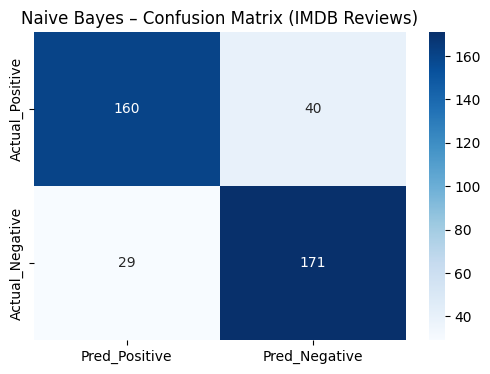


TP=160, FN=40, FP=29, TN=171


In [20]:
# -----------------------------
# 3. Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_test, y_pred, labels=["positive", "negative"])
cm_df = pd.DataFrame(cm,
                     index=["Actual_Positive", "Actual_Negative"],
                     columns=["Pred_Positive", "Pred_Negative"])

print("\n=== CONFUSION MATRIX ===")
print(cm_df)

# Visualize confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Naive Bayes – Confusion Matrix (IMDB Reviews)")
plt.show()

# Extract values
TP = cm[0,0]
FN = cm[0,1]
FP = cm[1,0]
TN = cm[1,1]

print(f"\nTP={TP}, FN={FN}, FP={FP}, TN={TN}")


In [21]:
# -----------------------------
# 4. Evaluation Metrics
# -----------------------------

accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label="positive")
recall    = recall_score(y_test, y_pred, pos_label="positive")
f1        = f1_score(y_test, y_pred, pos_label="positive")

print("\n=== METRICS ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))



=== METRICS ===
Accuracy : 0.8275
Precision: 0.8466
Recall   : 0.8000
F1-score : 0.8226

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

    negative       0.81      0.85      0.83       200
    positive       0.85      0.80      0.82       200

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



In [22]:
# -----------------------------
# 5. Interpretation of Naive Bayes
# -----------------------------

print("\n=== INTERPRETATION OF RESULTS ===")

if FN > FP:
    print("- The model is making more **False Negatives** (positive reviews predicted as negative).")
    print("  → This means the classifier struggles to detect subtle positive sentiment.")
    
if FP > FN:
    print("- The model is making more **False Positives** (negative reviews predicted as positive).")
    print("  → The model is confused by emotionally strong negative words that appear in positive contexts.")

print("- High precision means predictions marked as 'positive' are usually correct.")
print("- High recall means the model can successfully find most positive reviews.")
print("- A gap between precision and recall indicates bias toward one class.")

print("\nGeneral Observations:")
print("* Naive Bayes works well with TF-IDF because it assumes word independence.")
print("* However, it may misclassify reviews with mixed sentiment (e.g., 'The movie was good but slow').")
print("* It also struggles with sarcasm, irony, and highly figurative language.")



=== INTERPRETATION OF RESULTS ===
- The model is making more **False Negatives** (positive reviews predicted as negative).
  → This means the classifier struggles to detect subtle positive sentiment.
- High precision means predictions marked as 'positive' are usually correct.
- High recall means the model can successfully find most positive reviews.
- A gap between precision and recall indicates bias toward one class.

General Observations:
* Naive Bayes works well with TF-IDF because it assumes word independence.
* However, it may misclassify reviews with mixed sentiment (e.g., 'The movie was good but slow').
* It also struggles with sarcasm, irony, and highly figurative language.


In [23]:
# --- STEP 1: LOAD AND PREPROCESS ---

print("Loading IMDB dataset...")
# Load data (using a subset if needed for speed, here we load all)
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_data, test_data = dataset['train'], dataset['test']

# Helper function to convert tensorflow dataset to numpy arrays
def convert_to_numpy(data):
    texts = []
    labels = []
    for text, label in data:
        texts.append(text.numpy().decode('utf-8'))
        labels.append(label.numpy())
    return np.array(texts), np.array(labels)

# Convert to numpy for Scikit-Learn
X_train_raw, y_train = convert_to_numpy(train_data)
X_test_raw, y_test = convert_to_numpy(test_data)

print(f"Training samples: {len(X_train_raw)}")
print(f"Test samples: {len(X_test_raw)}")

# --- TEMPORARY STEP 2 (Prerequisite for you) ---
# We limit max_features to 2000 to prevent RAM crash during PCA Standardization
print("Generating TF-IDF features (Prerequisite for PCA)...")
tfidf = TfidfVectorizer(max_features=2000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train_raw)
X_test_tfidf = tfidf.transform(X_test_raw)

2025-12-05 15:38:54,143 : INFO : No config specified, defaulting to config: imdb_reviews/plain_text
2025-12-05 15:38:54,145 : INFO : Load dataset info from C:\Users\Rohit\tensorflow_datasets\imdb_reviews\plain_text\1.0.0
2025-12-05 15:38:54,150 : INFO : Creating a tf.data.Dataset reading 1 files located in folders: C:\Users\Rohit\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.
2025-12-05 15:38:54,188 : INFO : Creating a tf.data.Dataset reading 1 files located in folders: C:\Users\Rohit\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.
2025-12-05 15:38:54,215 : INFO : Creating a tf.data.Dataset reading 1 files located in folders: C:\Users\Rohit\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.
2025-12-05 15:38:54,239 : INFO : Constructing tf.data.Dataset imdb_reviews for split None, from C:\Users\Rohit\tensorflow_datasets\imdb_reviews\plain_text\1.0.0


Loading IMDB dataset...
Training samples: 25000
Test samples: 25000
Generating TF-IDF features (Prerequisite for PCA)...


## Step 6: Dimensionality Reduction with PCA
PCA requires the data to be centered (mean = 0) and scaled (variance = 1). This is a critical difference from SVD, which can work on sparse data.

Note: Standard PCA requires a dense matrix (not sparse). Converting a massive TF-IDF matrix to dense can crash a computer. This is why we limited max_features=2000 above.

Standardizing data...
Applying PCA to reduce dimensions to 100...


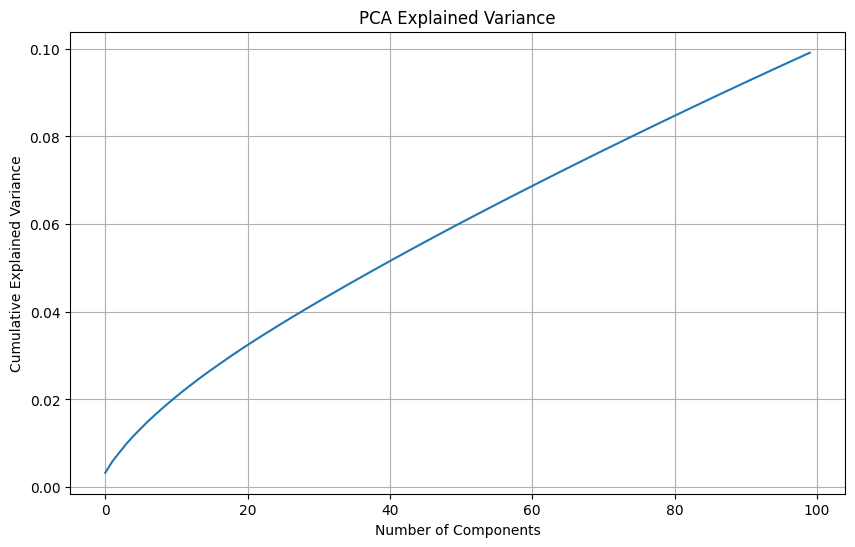

Total variance explained by 100 components: 0.10


In [24]:
# --- STEP 6: PCA IMPLEMENTATION ---

# 1. Standardize the data (Required for PCA)
# We must convert sparse TF-IDF to dense array first
print("Standardizing data...")
scaler = StandardScaler()
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

X_train_scaled = scaler.fit_transform(X_train_dense)
X_test_scaled = scaler.transform(X_test_dense)

# 2. Apply PCA
# We choose 100 components to match a typical SVD baseline
n_components = 100 
print(f"Applying PCA to reduce dimensions to {n_components}...")

pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 3. PCA Variance Curve (For comparison with Partner's SVD)
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

print(f"Total variance explained by {n_components} components: {np.sum(pca.explained_variance_ratio_):.2f}")

## Step 7: Model Training (Logistic Regression)
Now we train the classifier on the PCA-reduced data.

In [25]:
# --- STEP 7: LOGISTIC REGRESSION WITH PCA ---

print("Training Logistic Regression on PCA features...")
clf_pca = LogisticRegression(solver='liblinear') # liblinear is good for smaller datasets
clf_pca.fit(X_train_pca, y_train)

# Predict
y_pred_pca = clf_pca.predict(X_test_pca)

# Calculate Accuracy
acc = accuracy_score(y_test, y_pred_pca)
print(f"PCA + Logistic Regression Accuracy: {acc:.4f}")

Training Logistic Regression on PCA features...
PCA + Logistic Regression Accuracy: 0.8647


### Deliverable 1: Confusion Matrix Visualization
This code fulfills the "Confusion Matrix Requirements" section of your prompt.

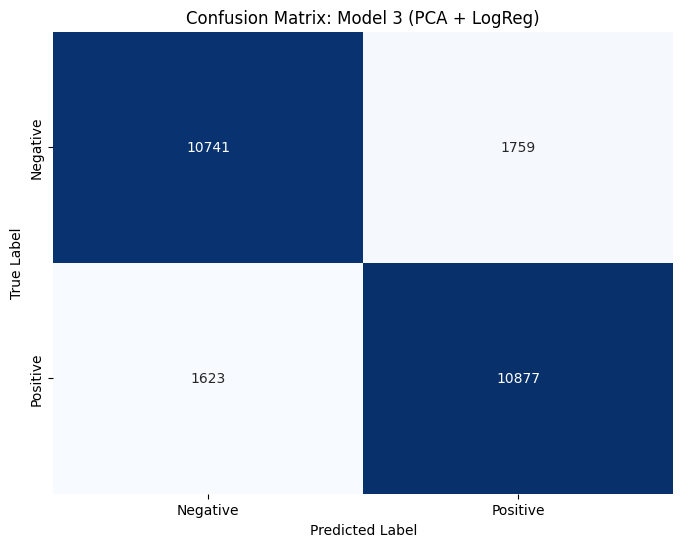


--- Interpretation Data ---
True Negatives (Correctly identified bad reviews): 10741
False Positives (Bad reviews thought to be good): 1759
False Negatives (Good reviews thought to be bad): 1623
True Positives (Correctly identified good reviews): 10877


In [26]:
# --- VISUALIZATION AND DELIVERABLES ---

# Generate Matrix
cm = confusion_matrix(y_test, y_pred_pca)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

plt.title('Confusion Matrix: Model 3 (PCA + LogReg)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Interpretation Helper
tn, fp, fn, tp = cm.ravel()
print("\n--- Interpretation Data ---")
print(f"True Negatives (Correctly identified bad reviews): {tn}")
print(f"False Positives (Bad reviews thought to be good): {fp}")
print(f"False Negatives (Good reviews thought to be bad): {fn}")
print(f"True Positives (Correctly identified good reviews): {tp}")

Analysis: PCA vs SVD (For your Step 7 analysis)
Since you need to compare this to your partner's SVD (LSA), here is the theoretical distinction you should look for in your analysis text:

Centering Data:

PCA: Requires centering data (subtracting the mean). In text data, the "zero" (sparsity) is meaningful—it means a word didn't appear. Centering destroys this sparsity, making the data "dense" and computationally heavy.

SVD: Can be applied directly to sparse matrices (without centering).

Performance:

SVD (LSA) generally performs better or equal to PCA for text data because it preserves the sparse structure of word counts.

If your PCA accuracy is significantly lower than your partner's SVD accuracy, the "Interpretation" is that standardization introduced noise or that the conversion to dense limited the number of features you could use (2,000 vs potential 50,000).



Deliverable 2: Model Architecture Summary
Here is the table row filled out for your report:

| Model    | Features              | Algorithm            | Purpose                                                                |
|----------|------------------------|-----------------------|-------------------------------------------------------------------------|
| Model 3  | PCA-reduced (Dense)    | Logistic Regression   | Compare dimensionality reduction methods (centering vs. sparsity)       |
